In [1]:
cd ..

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/ideal-word-representations


/home/jgauthie/om2/miniconda/envs/ideal/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
from pathlib import Path

import pandas as pd
import seaborn as sns

from transformers import TrainerState

from src.models import get_best_checkpoint

In [3]:
all_model_dirs = Path("outputs/models").glob("*/*")
checkpoints = [Path(get_best_checkpoint(d)) for d in all_model_dirs if not d.stem.startswith(".")]

In [4]:
trainer_states = [TrainerState.load_from_json(c / "trainer_state.json") for c in checkpoints]

In [5]:
log_df = pd.concat([pd.DataFrame(trainer_state.log_history) for trainer_state in trainer_states],
                   keys=[c.parent for c in checkpoints], names=["checkpoint"])
log_df

epoch  learning_rate  \
checkpoint                                                               
out/ce_model_phoneme_within_word_prefix_6_32 0     0.00       0.001000   
                                             1     0.00       0.000999   
                                             2     0.01       0.000997   
                                             3     0.01       0.000996   
                                             4     0.01       0.000995   
...                                                 ...            ...   
out/ce_model_phoneme_6_8                     184   0.38       0.000809   
                                             185   0.38       0.000808   
                                             186   0.39       0.000807   
                                             187   0.39       0.000805   
                                             188   0.39            NaN   

                                                    loss    step  eval_loss  \
checkpoint                                                                    
out/ce_model_phoneme_within_word_prefix_6_32 0   -2.1639     1.0        NaN   
                                             1   -2.4784    10.0        NaN   
                                             2   -3.0810    20.0        NaN   
                                             3   -4.0856    30.0        NaN   
                                             4   -4.8804    40.0        NaN   
...                                                  ...     ...        ...   
out/ce_model_phoneme_6_8                     184 -7.9528  1670.0        NaN   
                                             185 -8.2093  1680.0        NaN   
                                             186 -7.7255  1690.0        NaN   
                                             187 -7.2983  1700.0        NaN   
                                             188     NaN  1700.0  -8.382444   

                                                  eval_runtime  \
checkpoint                                                       
out/ce_model_phoneme_within_word_prefix_6_32 0             NaN   
                                             1             NaN   
                                             2             NaN   
                                             3             NaN   
                                             4             NaN   
...                                                        ...   
out/ce_model_phoneme_6_8                     184           NaN   
                                             185           NaN   
                                             186           NaN   
                                             187           NaN   
                                             188       30.9394   

                                                  eval_samples_per_second  \
checkpoint                                                                  
out/ce_model_phoneme_within_word_prefix_6_32 0                        NaN   
                                             1                        NaN   
                                             2                        NaN   
                                             3                        NaN   
                                             4                        NaN   
...                                                                   ...   
out/ce_model_phoneme_6_8                     184                      NaN   
                                             185                      NaN   
                                             186                      NaN   
                                             187                      NaN   
                                             188                  237.787   

                                                  eval_steps_per_second  \
checkpoint                                                                
out/ce_model_phoneme_within_word_prefix_6_32 0  

In [6]:
log_df_long = log_df.reset_index().melt(id_vars=["checkpoint", "step"], value_vars=["loss", "eval_loss"])
log_df_long

,checkpoint,step,variable,value
0,out/ce_model_phoneme_within_word_prefix_6_32,1.0,loss,-2.163900
1,out/ce_model_phoneme_within_word_prefix_6_32,10.0,loss,-2.478400
2,out/ce_model_phoneme_within_word_prefix_6_32,20.0,loss,-3.081000
3,out/ce_model_phoneme_within_word_prefix_6_32,30.0,loss,-4.085600
4,out/ce_model_phoneme_within_word_prefix_6_32,40.0,loss,-4.880400
...,...,...,...,...
3131,out/ce_model_phoneme_6_8,1670.0,eval_loss,NaN
3132,out/ce_model_phoneme_6_8,1680.0,eval_loss,NaN
3133,out/ce_model_phoneme_6_8,1690.0,eval_loss,NaN
3134,out/ce_model_phoneme_6_8,1700.0,eval_loss,NaN


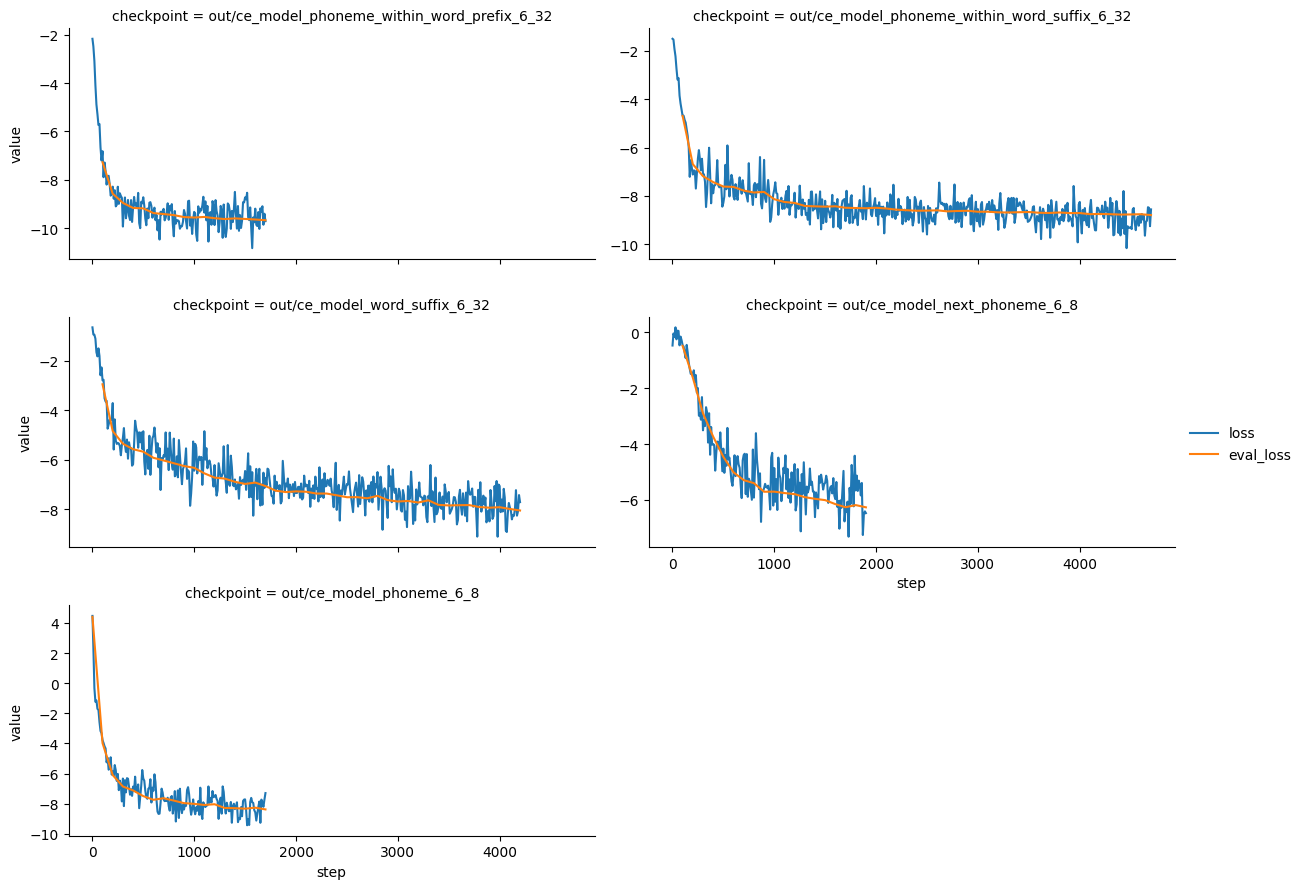

In [7]:
# Plot training and validation loss for all models
g = sns.FacetGrid(log_df_long, col="checkpoint", col_wrap=2, aspect=2, sharey=False)
g.map(sns.lineplot, "step", "value", "variable")
g.add_legend()